In [2]:

!pip install pyspark

!apt-get install openjdk-8-jdk-headless -qq > /dev/null

import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488490 sha256=7cfa3b6e056f9f642859490a3ff91deaea4003639de37f0c6f3faaac9fb37bbe
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [13]:
#Primera parte
#Importamos las librerias necesarias

import pyspark.pandas as pd

#Importamos el drive
from google.colab import drive
drive.mount('/content/drive')
#Ruta del archivo CSV en google drive
csv_path = '/content/drive/MyDrive/Colab Notebooks/insurance.csv'
#Cargamos los datos en un dataFrame de Spark con inferencia de esquema
df = spark.read.csv(csv_path, header=True, inferSchema=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
#Mostramos las primeras filas del dataset
print(df.head())

Row(age=19, sex='female', bmi=27.9, children=0, smoker='yes', region='southwest', charges=16884.924)


In [15]:
#resumen del dataset
print(df.describe())

DataFrame[summary: string, age: string, sex: string, bmi: string, children: string, smoker: string, region: string, charges: string]


In [18]:
#informacion sobre el dataset
print(df.printSchema())

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)

None


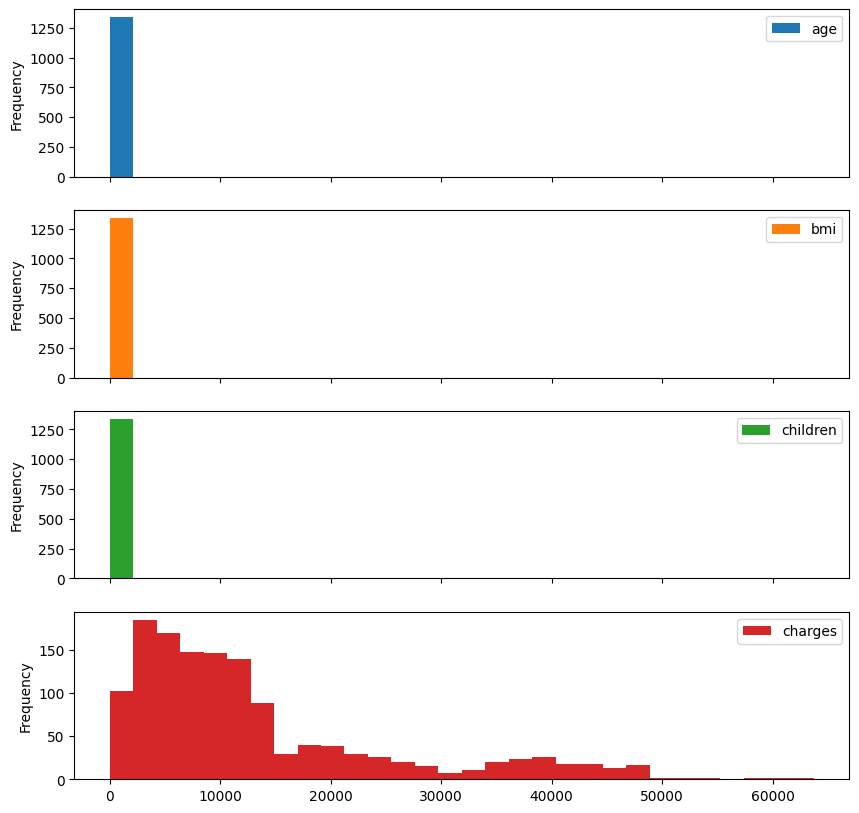

In [23]:
#analasis de las distribuciones de variables numericas
import matplotlib.pyplot as plt
import pyspark.pandas as pd

pandas_df = df.toPandas()

pandas_df[['age', 'bmi', 'children', 'charges']].plot.hist(subplots=True, bins=30, figsize=(10, 10))
plt.show()

In [26]:
#analisis de correlaciones
correlations = pandas_df[['age', 'bmi', 'children', 'charges']].corr()
print(correlations)

               age       bmi  children   charges
age       1.000000  0.109272  0.042469  0.299008
bmi       0.109272  1.000000  0.012759  0.198341
children  0.042469  0.012759  1.000000  0.067998
charges   0.299008  0.198341  0.067998  1.000000


In [27]:
#analisis de distribuciones de variables categoricas
print(pandas_df['sex'].value_counts())
print(pandas_df['smoker'].value_counts())
print(pandas_df['region'].value_counts())

sex
male      676
female    662
Name: count, dtype: int64
smoker
no     1064
yes     274
Name: count, dtype: int64
region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64


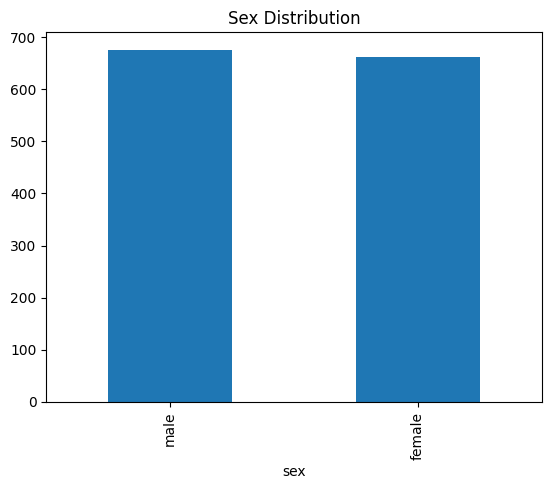

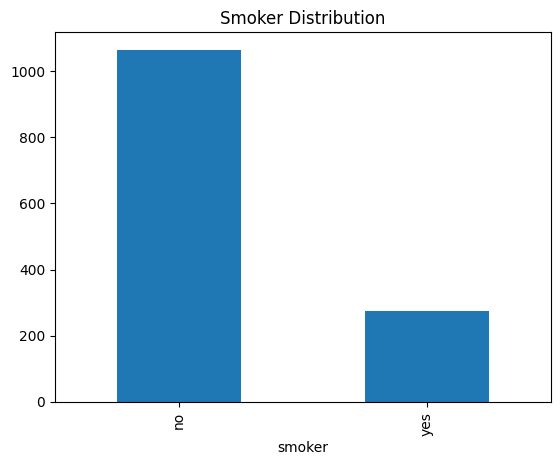

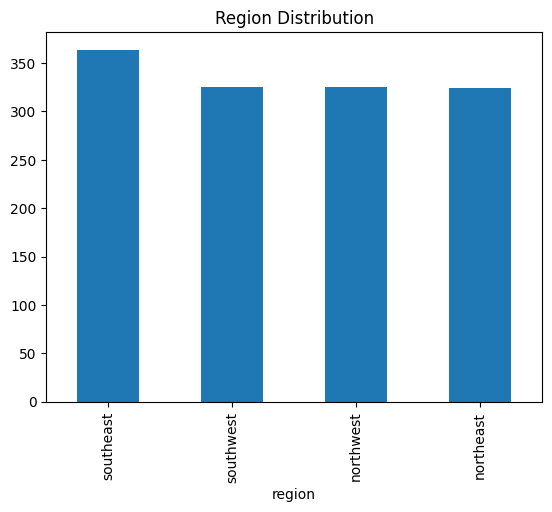

In [28]:
#Graficos de barras para variables categoricas
pandas_df['sex'].value_counts().plot(kind='bar', title ='Sex Distribution')
plt.show()
pandas_df['smoker'].value_counts().plot(kind='bar', title ='Smoker Distribution')
plt.show()
pandas_df['region'].value_counts().plot(kind='bar', title ='Region Distribution')
plt.show()

# SEGUNDA PARTE

In [29]:
#Importamos las librerias necesarias
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression

In [31]:
#creamos una sesion de spark
spark = SparkSession.builder.appName("insurance").getOrCreate()
#Convertimos el dataframe de pandas en spark dataframe
spark_df = spark.createDataFrame(pandas_df)

In [32]:
#convertimos las variables categoricas a numericas usando StringIndexer
indexer_sex = StringIndexer(inputCol="sex", outputCol="sex_index")
indexer_smoker = StringIndexer(inputCol="smoker", outputCol="smoker_index")
indexer_region = StringIndexer(inputCol="region", outputCol="region_index")

In [33]:
#Ajustamos los indexadores y transformamos el dataframe
spark_df = indexer_sex.fit(spark_df).transform(spark_df)
spark_df = indexer_smoker.fit(spark_df).transform(spark_df)
spark_df = indexer_region.fit(spark_df).transform(spark_df)

In [34]:
#ensamblamos todas las caracteristicas de un solo vector
assembler = VectorAssembler(inputCols=["age", "bmi", "children", "sex_index", "smoker_index", "region_index"], outputCol="features")

In [35]:
#transformamos el dataframe
assembled_df = assembler.transform(spark_df)

In [36]:
#estandarizamos las columnas relevantes para el modelo
final_df = assembled_df.select("features", "charges")

In [37]:
#dividimos el dataframe en conjuntos de entrenamiento y prueba
train_df, test_df = final_df.randomSplit([0.8, 0.2], seed=42)

In [38]:
#creamos el modelo de regresion lineal
lr = LinearRegression(featuresCol="features", labelCol="charges")

In [39]:
#entrenamos el modelo
lr_model = lr.fit(train_df)

In [40]:
#evaluamos el modelo en el conjunto de prueba
test_results = lr_model.evaluate(test_df)

In [41]:
#imprimimos las metricas del modelo
print("R2:", test_results.r2)
print("RMSE:", test_results.rootMeanSquaredError)

R2: 0.7365735674503378
RMSE: 6180.835745251796


In [42]:
#detenemos la sesion
spark.stop()